**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pathlib
import os
import glob
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras #type: ignore
from tensorflow.keras import layers #type: ignore
from tensorflow.keras.models import Sequential #type: ignore
from tensorflow.keras.regularizers import l2 #type: ignore
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping #type: ignore
from tensorflow.keras.preprocessing.image import load_img #type: ignore
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D #type: ignore
import random

#Importing Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Delete the below file and folder before creating same in the content**

In [2]:
!ls -lh /content  # List files
!rm -rf "/content/Skin cancer ISIC The International Skin Imaging Collaboration"
!rm -f "/content/Final_model_with_Augmentor.keras"
!ls -lh /content  # Verify deletion

total 8.0K
drwx------ 5 root root 4.0K Sep 17 18:05 drive
drwxr-xr-x 1 root root 4.0K Sep 16 13:27 sample_data
total 8.0K
drwx------ 5 root root 4.0K Sep 17 18:05 drive
drwxr-xr-x 1 root root 4.0K Sep 16 13:27 sample_data


**Unzip the CNN file and store the image data in the content**

In [3]:
#UnZip the Data Set
!unzip "/content/drive/MyDrive/Suraj/Project_Data_Set/Melanoma_Detection_Data_Set/CNN_assignment.zip" -d /content/
drive.flush_and_unmount()

Archive:  /content/drive/MyDrive/Suraj/Project_Data_Set/Melanoma_Detection_Data_Set/CNN_assignment.zip
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: /c

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
filepath = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/'
data_dir_train = pathlib.Path(filepath + 'Train')
data_dir_test = pathlib.Path(filepath + 'Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

***Function***
Image Split for data set

In [7]:
## Train dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

def image_loader_split(data_set, subset_type, validation_split):
  """
  To assign batch_size, image_height and image_width and seed value
  split the train data set and validation data set (80:20) ratio

  Args:
      data_set (str): A string representing the path to the directory containing
                      the images.
      subset_type (str): A string representing the type of subset to create.
      validation_split (float): A float representing the percentage of the data
                                to use for validation.

  Returns:
      A tf.data.Dataset object representing the loaded images.
  """
  data_pre = tf.keras.utils.image_dataset_from_directory(
    directory=data_set,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    label_mode="int",
    validation_split=validation_split,
    subset=subset_type
  )
  return data_pre

In [8]:
## Train dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_loader_split(data_dir_train, 'training', 0.2)

## Validation dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_loader_split(data_dir_train, 'validation', 0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
##Test Data Set
test_ds = image_loader_split(data_dir_test, None, 0.0)

Found 118 files belonging to 9 classes.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
print('Number of classes are',len(class_names))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Number of classes are 9


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [11]:
#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,random.sample(os.listdir(str(data_dir_train)+'/'+c), 1)))

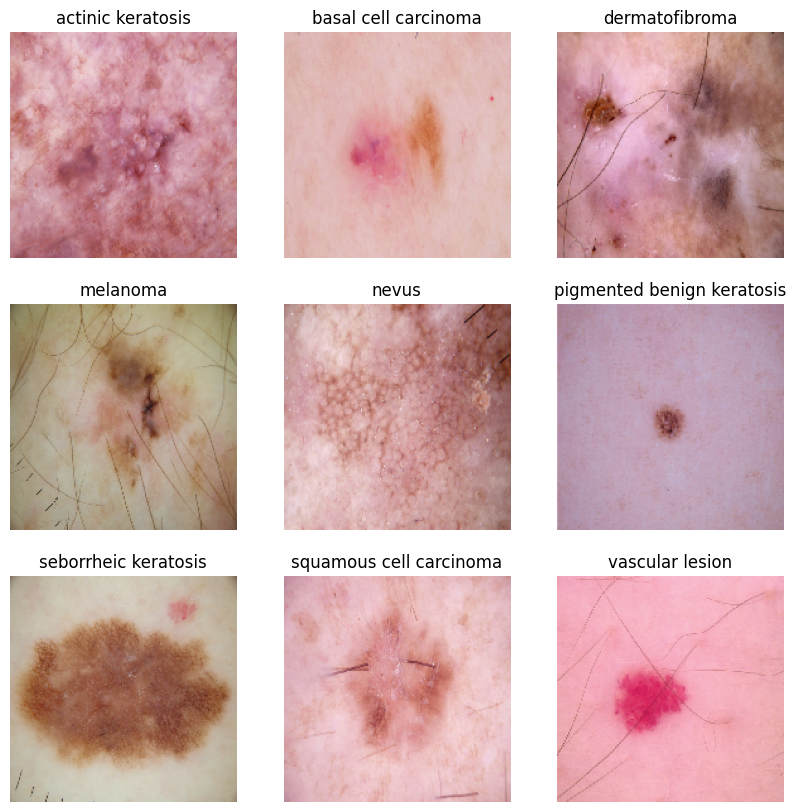

In [12]:
#Visualize image
plt.figure(figsize=(10,10))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(tf.keras.utils.load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [72]:
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),

  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),

  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.Conv2D(128, (3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),

  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

### Compile the model

In [73]:
#Compile the Model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [74]:
# View the summary of all layers
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 41, 41, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,506,537 (101.11 MB)

 Trainable params: 26,506,537 (101.11 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [75]:
epochs = 20
tf.random.set_seed(1)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.2247 - loss: 2.1053 - val_accuracy: 0.1790 - val_loss: 2.3376
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.2895 - loss: 1.8633 - val_accuracy: 0.3826 - val_loss: 1.7023
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.3475 - loss: 1.7430 - val_accuracy: 0.4072 - val_loss: 1.6787
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.3875 - loss: 1.6625 - val_accuracy: 0.4385 - val_loss: 1.5526
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.3951 - loss: 1.6200 - val_accuracy: 0.4318 - val_loss: 1.5865
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.4831 - loss: 1.4392 - val_accuracy: 0.4653 - val_loss: 1.5023
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.5167 - loss: 1.3716 - val_accuracy: 0.5123 - val_loss: 1.4639
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.5170 - loss: 1.3539 - val_accuracy: 0.5190 -

**Result on Test data set**

* Test data set (80%)
    - Accuracy - `0.8500`
    - Loss - `0.4162`

* Validation data set (20%)
    - Accuracy - `0.4653`
    - Loss - `2.6695`

### Visualizing training results

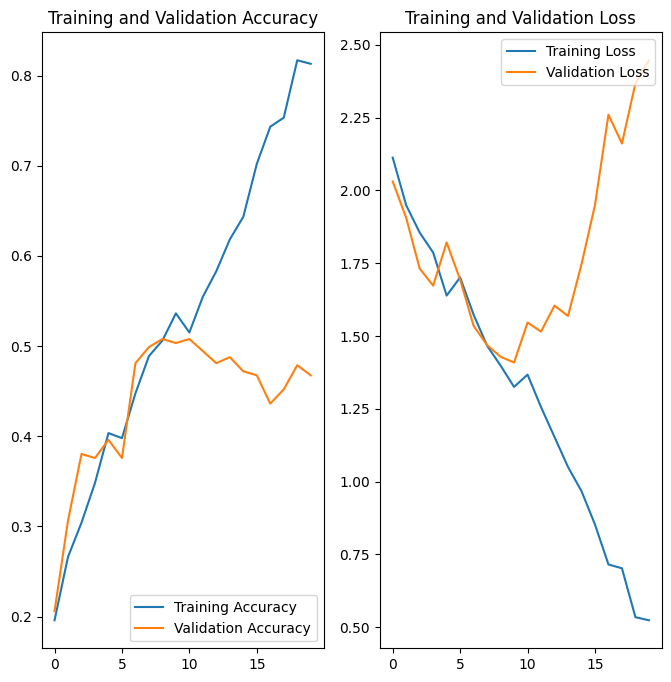

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This image contains two graphs showing the `training and validation` performance of a machine learning model over `20 epochs`.

### Left Graph: Training and Validation Accuracy
- **Blue Line (Training Accuracy):** The training accuracy shows a steady increase throughout the epochs, reaching around `0.85` by the final epoch. This indicates that the model is learning the training data well.
- **Orange Line (Validation Accuracy):** The validation accuracy rises initially but plateaus and even slightly `decreases after around 10 epochs`, indicating that the model is struggling to generalize well on the validation set.
  
**Interpretation:** This could suggest that the model is overfitting after a certain number of epochs since the training accuracy improves while the validation accuracy stagnates or drops.

### Right Graph: Training and Validation Loss
- **Blue Line (Training Loss):** The training loss decreases steadily and significantly over time, which is expected as the model learns the training data.
- **Orange Line (Validation Loss):** The validation `loss decreases` initially but begins to rise after around `epoch 10`, showing a clear sign of `overfitting` as the model's performance on `unseen data worsens`.

**Overall Interpretation:** `The model is likely overfitting`, as evidenced by the divergence between training and validation performance after around epoch 10.

### **Utilising Image Augmentation to reduce overfitting**

True


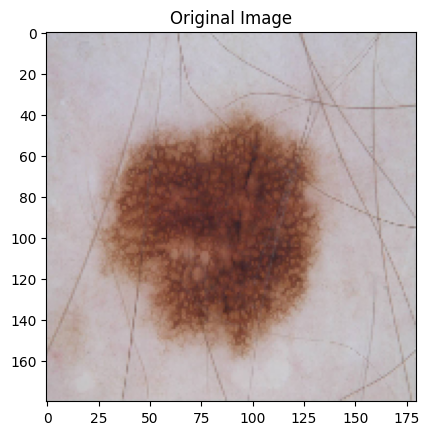

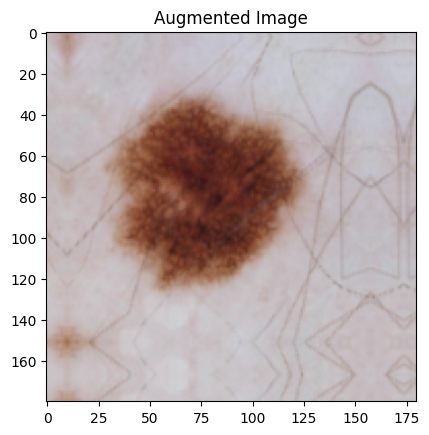

In [93]:
# Set the directory and image path
im_path = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000019.jpg'

# Check if the image exists
print(os.path.exists(im_path))

# Load the image and display the original image
img = tf.keras.preprocessing.image.img_to_array(tf.keras.utils.load_img(
    im_path, target_size=(180, 180)))
plt.imshow(img / 255.)  # Normalize pixel values for visualization
plt.title("Original Image")
plt.show()

data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2, fill_mode='reflect'),
    layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect'),
    layers.RandomContrast(0.2),  # Added contrast adjustment
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='reflect')  # Added translation
])
augmented_img = data_augmentation(tf.convert_to_tensor(img))  # Convert the image to a tensor and apply augmentation
plt.imshow(augmented_img / 255.)  # Normalize augmented image for display
plt.title("Augmented Image")
plt.show()

### Creating the model with Image Augumentation

In [42]:
## Utilising Tensorflow's inbuild layer for performing data augmentation. This layer can be included as part of the model, and runs on only training data
# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2, fill_mode='reflect'),
    layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect'),
    layers.RandomContrast(0.2),  # Added contrast adjustment
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='reflect')  # Added translation
])

In [76]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  data_augmentation,

  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),

  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),

  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, (3,3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.5),

  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
  layers.Dropout(0.5),

  layers.Dense(num_classes, activation='softmax')
])

In [77]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_66 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_67 (Conv2D)                   │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 89, 89, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_69 (Conv2D)                   │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_70 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 43, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_71 (Conv2D)                   │ (None, 41, 41, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,508,329 (101.12 MB)

 Trainable params: 26,507,433 (101.12 MB)

 Non-trainable params: 896 (3.50 KB)

In [79]:
# Training for 20 epochs
epochs=20
tf.random.set_seed(1)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.4294 - loss: 2.0228 - val_accuracy: 0.4519 - val_loss: 2.0496
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 0.4470 - loss: 1.9701 - val_accuracy: 0.3669 - val_loss: 3.2206
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - accuracy: 0.4539 - loss: 1.9112 - val_accuracy: 0.4743 - val_loss: 2.2350
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - accuracy: 0.4131 - loss: 2.0530 - val_accuracy: 0.3043 - val_loss: 3.4338
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.4510 - loss: 2.0206 - val_accuracy: 0.5347 - val_loss: 1.8987
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.4410 - loss: 1.9904 - val_accuracy: 0.5168 - val_loss: 2.0458
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.4224 - loss: 2.0887 - val_accuracy: 0.4609 - val_loss: 2.0770
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.4751 - loss: 1.9922 - val_accu

**Result on Test data set**

* Test data set (80%)
    - Accuracy - `0.4657`
    - Loss - `1.7991`

* Validation data set (20%)
    - Accuracy - `0.4586`
    - Loss - `1.8813`

* Here we have reduces the model overfit issue but test accuracy declined and model result is not good in terms of accuracy and loss numbers of test and validation data set and we have class imbalance also

### Visualizing training results

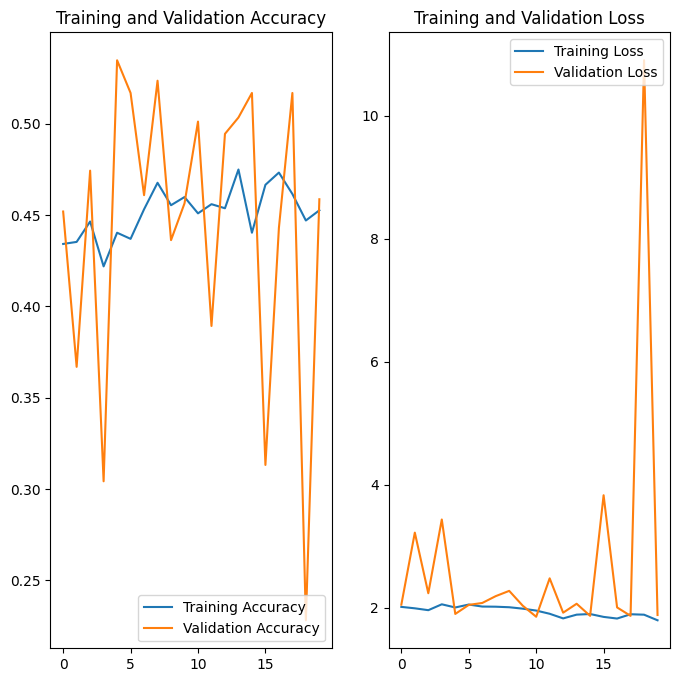

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The second image shows two similar plots for `training and validation accuracy (left) and loss (right)`, but with a very different trend from the previous image.

### Left Graph: Training and Validation Accuracy
- **Blue Line (Training Accuracy):** The training accuracy remains relatively `flat around 0.45`, indicating that the model is struggling to learn the training data.
- **Orange Line (Validation Accuracy):** The validation accuracy is extremely volatile, oscillating between very high and low values `(from almost 0 to around 0.5)`. This inconsistency suggests that the model is not stable and struggles with generalization.

### Right Graph: Training and Validation Loss
- **Blue Line (Training Loss):** The training loss remains relatively constant, hovering around the same value with `minor fluctuations, indicating no significant improvement in learning`.
- **Orange Line (Validation Loss):** The validation loss is highly erratic, with sharp spikes, especially towards the end (reaching as high as 10). This further indicates the model's instability and inability to generalize effectively.

### Comparison with the Previous Image
- **Training Performance:** In the previous image, the training accuracy increased consistently while the training loss steadily decreased, indicating good learning. In the current image, the training accuracy and loss are nearly flat, suggesting that the model is not learning well from the data.
- **Validation Performance:** In both cases, the validation performance exhibits instability, but it is far more volatile in the current image. The previous image shows validation accuracy plateauing, while the current image shows severe fluctuation. Similarly, the validation loss in the previous image increased gradually, signaling overfitting, whereas in the current image, the loss has extreme spikes, indicating a much greater level of instability.
  
### Conclusion
- **Previous Image:** The model was overfitting after several epochs, but still showed clear learning from the training data.
- **Current Image:** The model is not learning effectively, with both the training and validation performance being highly unstable. It suggests potential issues with the model's architecture & data quality.


### Checking for presence of Class Imbalance

In [50]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,vascular lesion,139
1,dermatofibroma,95
2,actinic keratosis,114
3,seborrheic keratosis,77
4,pigmented benign keratosis,462
5,nevus,357
6,squamous cell carcinoma,181
7,basal cell carcinoma,376
8,melanoma,438


<Axes: xlabel='No. of Image', ylabel='Class'>

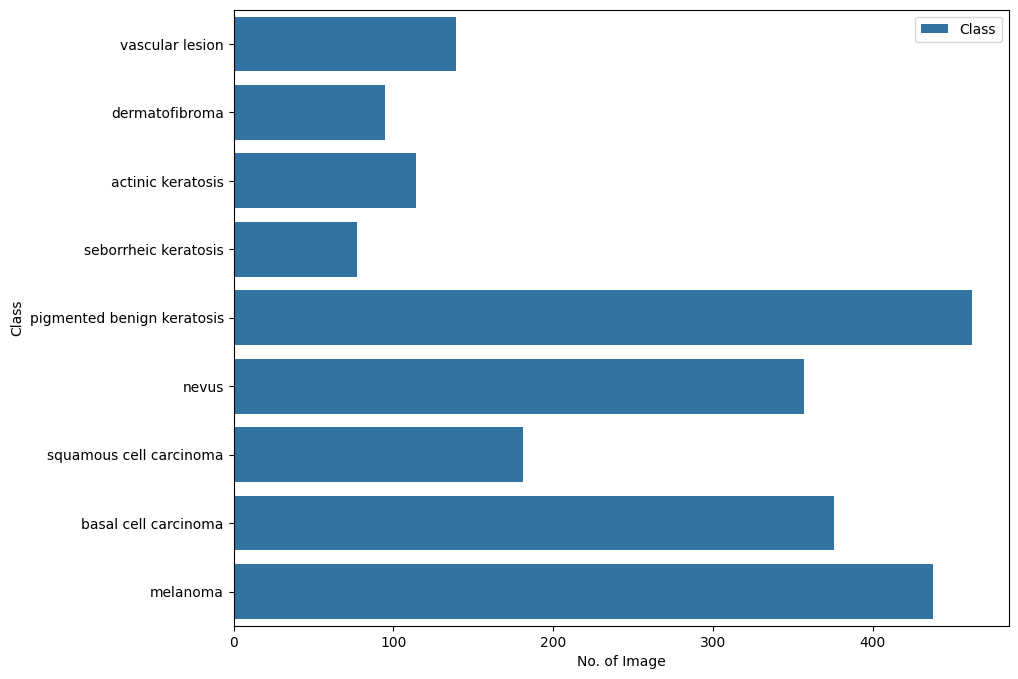

In [51]:
#Visualize the Number of image in each class.
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df, label="Class")
plt.show()

The image represents a horizontal bar chart showing the distribution of images across different skin cancer-related classes. Here's a breakdown and analysis of the chart:

### Observations:
1. **Classes**: There are several categories related to skin lesions, including:
   - **Vascular lesion**
   - **Dermatofibroma**
   - **Actinic keratosis**
   - **Seborrheic keratosis**
   - **Pigmented benign keratosis**
   - **Nevus**
   - **Squamous cell carcinoma**
   - **Basal cell carcinoma**
   - **Melanoma**

2. **Distribution of Images**:
   - **Melanoma** & **Pigmented benign keratosis** have the highest number of images, each exceeding 400 images.
   - **Nevus** & **Basal cell carcinoma**also has a significant number of images, slightly less than melanoma.
   - **Squamous cell carcinoma** & **Vascular lesion** are mid-range, each with around 150 to 250 images.
   - **Dermatofibroma**, **Actinic keratosis**, and **Seborrheic keratosis** have fewer images, with **Seborrheic keratosis** having the smallest representation in the dataset.

### Insights:
1. **Class Imbalance**:
   - There appears to be a class imbalance, with classes like **Melanoma** and **Pigmented benign keratosis** having a significantly higher representation compared to others like **Dermatofibroma** and **Seborrheic keratosis**.
   - This imbalance may affect the performance of the model, potentially leading to biased predictions favoring the larger classes.
   
2. **Model Performance**:
   - To ensure better generalization across all classes, balancing techniques such as oversampling the smaller classes or undersampling the larger ones, or using weighted losses during training, may be necessary.
   - Another approach could be the use of data augmentation to artificially increase the number of images in underrepresented classes.

3. **Focus on Common Classes**:
   - The dataset is well-represented for classes like **Melanoma**, **Pigmented benign keratosis**, and **Nevus**, which could lead to a model that performs particularly well for these common conditions.

4. **Risk of Overfitting**:
   - With some classes having fewer images, there's a risk that the model might overfit to those underrepresented classes during training.

This analysis suggests that class distribution needs to be handled carefully to ensure a fair and robust model performance across all categories.

To handle this class imbalance we will use `Augmentor`

#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
!pip install Augmentor

In [28]:
path_to_training_dataset=data_dir_train
import Augmentor # type:ignore
for i in class_names:
    p = Augmentor.Pipeline(pathlib.Path.joinpath(path_to_training_dataset,i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10) # 10 degree rotation
    p.sample(500) ## We are adding 1000 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DA060219ED0>: 100%|██████████| 500/500 [00:18<00:00, 27.05 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DA06021A980>: 100%|██████████| 500/500 [00:20<00:00, 24.14 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DA080E5FD30>: 100%|██████████| 500/500 [00:17<00:00, 27.79 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7DA080EA49A0>: 100%|██████████| 500/500 [01:13<00:00,  6.85 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7DA080E0D810>: 100%|██████████| 500/500 [01:14<00:00,  6.74 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D9FFF15D810>: 100%|██████████| 500/500 [00:15<00:00, 32.56 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DA080E73C40>: 100%|██████████| 500/500 [00:35<00:00, 14.17 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DA080FD43A0>: 100%|██████████| 500/500 [00:14<00:00, 33.35 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DA07DFBFEE0>: 100%|██████████| 500/500 [00:14<00:00, 33.55 Samples/s]


In [52]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [53]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list]

In [54]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
augemented_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','class_names'])
augemented_df

,Path,class_names
0,/content/Skin cancer ISIC The International Sk...,vascular lesion
1,/content/Skin cancer ISIC The International Sk...,vascular lesion
2,/content/Skin cancer ISIC The International Sk...,vascular lesion
3,/content/Skin cancer ISIC The International Sk...,vascular lesion
4,/content/Skin cancer ISIC The International Sk...,vascular lesion
...,...,...
4495,/content/Skin cancer ISIC The International Sk...,melanoma
4496,/content/Skin cancer ISIC The International Sk...,melanoma
4497,/content/Skin cancer ISIC The International Sk...,melanoma
4498,/content/Skin cancer ISIC The International Sk...,melanoma


### Create a dataset on Augemented data set with default parameter

In [55]:
## Train dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
aug_train_ds = image_loader_split(data_dir_train, 'training', 0.2)

## Validation dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
aug_val_ds = image_loader_split(data_dir_train, 'validation', 0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [56]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = aug_train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Training the model on the data created using Augmentor

In [57]:
# prefetching the dataset
AUTOTUNE = tf.data.AUTOTUNE
aug_train_ds = aug_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
aug_val_ds = aug_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [83]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),

  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),

  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, (3,3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.5),

  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
  layers.Dropout(0.5),

  layers.Dense(num_classes, activation='softmax')
])

In [84]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_12 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_72 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_60               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_73 (Conv2D)                   │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_61               │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_74 (Conv2D)                   │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_62               │ (None, 89, 89, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_75 (Conv2D)                   │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_63               │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_76 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_64               │ (None, 43, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_77 (Conv2D)                   │ (None, 41, 41, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_65               │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,508,329 (101.12 MB)

 Trainable params: 26,507,433 (101.12 MB)

 Non-trainable params: 896 (3.50 KB)

In [88]:
# Training for 20 epochs
epochs = 20
tf.random.set_seed(1)
history = model.fit(
  aug_train_ds,
  validation_data=aug_val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.7932 - loss: 2.6821 - val_accuracy: 0.1544 - val_loss: 29.6860
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.8036 - loss: 2.6555 - val_accuracy: 0.6162 - val_loss: 3.3479
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.8061 - loss: 2.5390 - val_accuracy: 0.7565 - val_loss: 2.7402
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.8069 - loss: 2.6002 - val_accuracy: 0.7298 - val_loss: 3.0065
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.8009 - loss: 2.6767 - val_accuracy: 0.6756 - val_loss: 3.1492
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.8206 - loss: 2.5348 - val_accuracy: 0.5538 - val_loss: 3.6280
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.8121 - loss: 2.5381 - val_accuracy: 0.7439 - val_loss: 2.8042
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.8183 - loss: 2.62

**Result on Test data set**

* Test data set (80%)
    - Accuracy - `0.8461`
    - Loss - `2.290`

* Validation data set (20%)
    - Accuracy - `0.7751`
    - Loss - `2.7418`

* Here we have reduces the model overfit issue compared first model to prevented the class imbalance which helped us to good accuracy score on test and validation data compared pervious model but still we have potential ovefit issue but it reduces the overfit from first model

**Visualizing the model results**

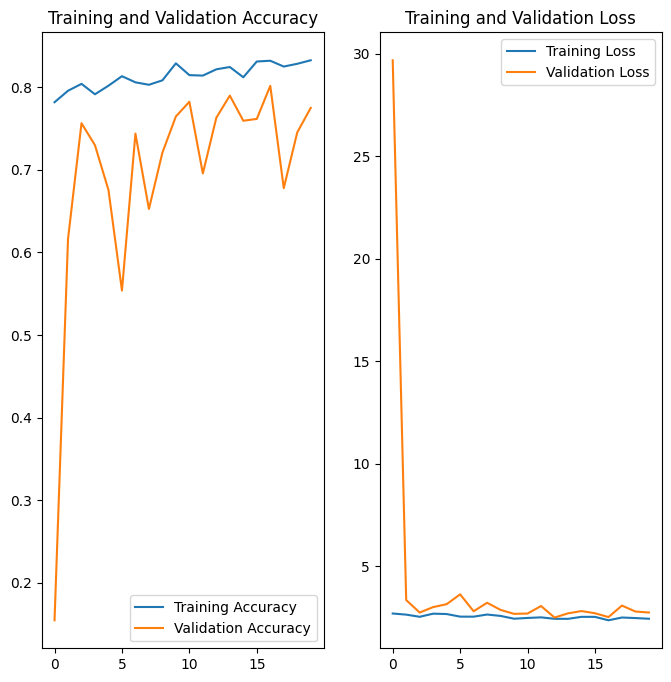

In [89]:
aug_acc = history.history['accuracy']
aug_val_acc = history.history['val_accuracy']

aug_loss = history.history['loss']
aug_val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, aug_acc, label='Training Accuracy')
plt.plot(epochs_range, aug_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, aug_loss, label='Training Loss')
plt.plot(epochs_range, aug_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This new image provides another comparison of training and validation performance over 20 epochs, but it shows significantly better behavior than the previous two images.

### Left Graph: Training and Validation Accuracy
- **Blue Line (Training Accuracy):** The training accuracy remains high, around 0.85, from the very beginning, with a steady improvement toward the end. This suggests that the model is learning the training data very well from early on.
- **Orange Line (Validation Accuracy):** The validation accuracy also starts relatively high (~0.7) and maintains its level with minor fluctuations throughout the epochs. The validation accuracy mirrors the training accuracy to some extent, indicating better generalization compared to the earlier images.

### Right Graph: Training and Validation Loss
- **Blue Line (Training Loss):** The training loss starts very low and decreases slightly over time, indicating effective learning without significant overfitting.
- **Orange Line (Validation Loss):** The validation loss starts extremely high (~30) but drops sharply in the first few epochs. After the initial decrease, it stays close to the training loss, showing minor fluctuations, which suggests much better model stability and generalization compared to the previous images.

### Comparison with Previous Images

#### Training Accuracy:
- **First Image:** Training accuracy steadily increased throughout the epochs, reaching high values but with signs of overfitting as the validation accuracy declined.
- **Second Image:** The training accuracy was mostly flat, indicating poor learning overall.
- **Current Image:** Training accuracy starts high and remains steady, suggesting that the model is learning effectively from the beginning.

#### Validation Accuracy:
- **First Image:** Validation accuracy initially increased but plateaued and slightly decreased after about 10 epochs, indicating overfitting.
- **Second Image:** Validation accuracy was highly volatile and unstable, with sharp fluctuations.
- **Current Image:** Validation accuracy remains stable, with minor fluctuations, indicating much better generalization than in the previous images.

#### Training Loss:
- **First Image:** Training loss decreased steadily, indicating learning, but validation loss increased, signaling overfitting.
- **Second Image:** Training loss remained mostly flat, indicating that the model was not learning effectively.
- **Current Image:** Training loss starts low and decreases slightly, indicating effective and stable learning without significant overfitting.

#### Validation Loss:
- **First Image:** Validation loss started decreasing but increased after about 10 epochs, indicating overfitting.
- **Second Image:** Validation loss was highly erratic, showing instability in the model's performance.
- **Current Image:** Validation loss starts high but drops dramatically in the first few epochs, stabilizing afterward. This indicates that the model quickly learned to generalize better, avoiding the instability seen in the second image and the overfitting seen in the first.

### Conclusion
- **First Image:** Shows a model that learns well initially but starts overfitting after around 10 epochs.
- **Second Image:** Indicates a poorly trained model with significant instability and failure to learn from the data.
- **Current Image:** Demonstrates a well-trained model with both good training accuracy and validation performance, showing minimal overfitting and good generalization across the epochs. This is by far the best performing model of the three.

In [90]:
# saving the model for future use
model.save("Final_model_with_Augmentor.keras")

### **On Test Data Set**

In [91]:
# Loading the saved model
model = tf.keras.models.load_model("Final_model_with_Augmentor.keras") # type:ignore

# model summary
model.summary() #type:ignore

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_12 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_72 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_60               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_73 (Conv2D)                   │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_61               │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_74 (Conv2D)                   │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_62               │ (None, 89, 89, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_75 (Conv2D)                   │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_63               │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_76 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_64               │ (None, 43, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_77 (Conv2D)                   │ (None, 41, 41, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_65               │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 79,523,197 (303.36 MB)

 Trainable params: 26,507,433 (101.12 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 53,014,868 (202.24 MB)

In [92]:
# evaluate the model on the test dataset
model.evaluate(test_ds) #type: ignore

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 814ms/step - accuracy: 0.4573 - loss: 4.8990


[5.144474029541016, 0.43220338225364685]